<a href="https://colab.research.google.com/github/a77lic7ion/Clone-TTS/blob/main/Chatterbox_(TTS_%2B_Voice_Clone).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chatterbox TTS Google Colab Script
==================================

A comprehensive script for text-to-speech generation and voice cloning using
Chatterbox TTS in Google Colab environment.


---


- Author: Ujjwal Nova
- License: MIT
- Repository: https://github.com/UKR-PROJECTS/chatterbox-tts-colab


---


Features:
- Automatic dependency installation with fallbacks
- Voice cloning from audio samples
- Long text processing with chunking
- Google Drive integration
- Robust error handling
- GPU/CPU automatic detection



---



Cell 1: Installation and Dependencies

---
Run this cell first, then WAIT for kernel restart

In [ ]:
import subprocess
import sys
import os
from pathlib import Path

def run_command(command, description=""):
    """Run a command and handle errors gracefully"""
    print(f"Running: {description if description else command}")
    try:
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Warning: {description} failed with return code {result.returncode}")
            print(f"stderr: {result.stderr}")
            print(f"stdout: {result.stdout}")
            return False
        else:
            print(f"Success: {description}")
            return True
    except Exception as e:
        print(f"Error running command: {e}")
        return False

print(f"Python version: {sys.version}")

# Update pip first
run_command("pip install --upgrade pip", "Upgrading pip")

# Install PyTorch (CPU version for compatibility)
print("Installing PyTorch...")
run_command(
    "pip install torch torchaudio --index-url https://download.pytorch.org/whl/cpu --force-reinstall",
    "Installing PyTorch (CPU version for stability)"
)

# Install git-lfs for handling large files
run_command("apt update && apt install -y git-lfs", "Installing git-lfs")

# Install chatterbox-tts
print("Installing Chatterbox TTS...")
chatterbox_success = run_command(
    "pip install chatterbox-tts --no-cache-dir --force-reinstall",
    "Installing Chatterbox TTS"
)

if not chatterbox_success:
    print("PyPI installation failed. Trying GitHub installation...")
    run_command(
        "git clone https://github.com/resemble-ai/chatterbox.git /tmp/chatterbox",
        "Cloning Chatterbox repository"
    )
    run_command(
        "cd /tmp/chatterbox && pip install -e .",
        "Installing Chatterbox from source"
    )

# Fix for protobuf error
print("Fixing protobuf version conflict...")
run_command("pip uninstall -y protobuf", "Uninstalling existing protobuf")
run_command("pip install protobuf==3.20.3", "Installing compatible protobuf version")


print("\n🔄 Dependencies installed. Restarting kernel...")
print("⚠️  WAIT for kernel restart, then run the next cell!")
get_ipython().kernel.do_shutdown(True)

Cell 2: Verify Installation

---


Run this cell after kernel restart

In [2]:
# Verify installation
try:
    import torch
    import torchaudio
    from chatterbox.tts import ChatterboxTTS
    print("✅ All imports successful!")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please run the installation cell again")

✅ All imports successful!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4


Cell 3: Google Drive Setup

---


Run this cell to set up Google Drive

In [3]:
from google.colab import drive
import os

def setup_drive():
    """Setup Google Drive mount and create necessary directories"""
    try:
        drive.mount('/content/drive')
        drive_path = '/content/drive/MyDrive/Chatterbox'
        os.makedirs(drive_path, exist_ok=True)
        print(f"✅ Drive setup complete: {drive_path}")
        return drive_path
    except Exception as e:
        print(f"❌ Drive setup failed: {e}")
        return None

DRIVE_PATH = setup_drive()

Mounted at /content/drive
✅ Drive setup complete: /content/drive/MyDrive/Chatterbox


Cell 4: Model Loading with Advanced Configuration

---


Load the Chatterbox model

In [4]:
import torch
from chatterbox.tts import ChatterboxTTS

def load_model(max_retries=3):
    """Load the Chatterbox model with retry logic"""
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Loading model on device: {device}")

        model = ChatterboxTTS.from_pretrained(device=device)
        print("✅ Model loaded successfully")
        return model

    except Exception as e:
        print(f"❌ Model loading failed: {e}")
        print("Trying CPU fallback...")

        try:
            model = ChatterboxTTS.from_pretrained(device="cpu")
            print("✅ Model loaded successfully on CPU")
            return model
        except Exception as e2:
            print(f"❌ CPU fallback also failed: {e2}")
            raise e2

# Load the model
model = load_model()

Loading model on device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ve.safetensors:   0%|          | 0.00/5.70M [00:00<?, ?B/s]

t3_cfg.safetensors:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

s3gen.safetensors:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

conds.pt:   0%|          | 0.00/107k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


loaded PerthNet (Implicit) at step 250,000
✅ Model loaded successfully


Cell 5: Advanced Controls Configuration

---


Configure advanced parameters for voice generation

In [5]:
# 🎛️ ADVANCED CONTROLS - Adjust these parameters for different effects

class ChatterboxConfig:
    """Advanced configuration for Chatterbox TTS"""

    def __init__(self):
        # 🎭 EXAGGERATION CONTROL (0.0 - 2.0)
        # Controls emotional intensity and expressiveness
        # 0.5 = Neutral (default)
        # 0.3-0.4 = Subtle, calm
        # 0.6-0.8 = More expressive
        # 1.0+ = Very dramatic
        self.exaggeration = 0.5

        # ⚡ CFG WEIGHT (0.1 - 1.0)
        # Controls adherence to reference audio style
        # 0.3 = Faster pacing, less strict adherence
        # 0.5 = Balanced (default)
        # 0.7+ = Slower, more faithful to reference
        self.cfg_weight = 0.5

        # 📏 TEXT CHUNKING
        # Maximum words per chunk (recommended: 30-100)
        self.max_chunk_words = 50

        # 🎤 VOICE CLONING SETTINGS
        # Minimum recommended audio length: 10 seconds
        # Optimal format: WAV, 16-22kHz sample rate
        self.voice_sample_path = None

    def get_preset(self, preset_name):
        """Get predefined parameter presets"""
        presets = {
            "neutral": {"exaggeration": 0.5, "cfg_weight": 0.5},
            "calm": {"exaggeration": 0.3, "cfg_weight": 0.6},
            "expressive": {"exaggeration": 0.7, "cfg_weight": 0.4},
            "dramatic": {"exaggeration": 1.0, "cfg_weight": 0.3},
            "storytelling": {"exaggeration": 0.8, "cfg_weight": 0.4},
            "audiobook": {"exaggeration": 0.4, "cfg_weight": 0.6},
            "fast_speaker": {"exaggeration": 0.6, "cfg_weight": 0.3},
        }
        return presets.get(preset_name, presets["neutral"])

# Initialize configuration
config = ChatterboxConfig()

# 🎚️ CHOOSE YOUR PRESET OR CUSTOMIZE
# Uncomment one of these lines:

# config.__dict__.update(config.get_preset("neutral"))      # Balanced, natural
# config.__dict__.update(config.get_preset("expressive"))   # More emotional
# config.__dict__.update(config.get_preset("storytelling")) # Great for narratives
# config.__dict__.update(config.get_preset("audiobook"))    # Clear, consistent
# config.__dict__.update(config.get_preset("dramatic"))     # Very expressive

# OR customize manually:
config.exaggeration = 0.6  # Adjust 0.0-2.0
config.cfg_weight = 0.4     # Adjust 0.1-1.0

print(f"🎛️ Current settings:")
print(f"   Exaggeration: {config.exaggeration}")
print(f"   CFG Weight: {config.cfg_weight}")
print(f"   Chunk size: {config.max_chunk_words} words")

🎛️ Current settings:
   Exaggeration: 0.6
   CFG Weight: 0.4
   Chunk size: 50 words


Cell 6: Voice Sample Setup (Optional)

---


Set up voice cloning with your own audio

In [6]:
# 🎤 VOICE CLONING SETUP

def setup_voice_cloning():
    """Setup voice cloning with instructions"""
    print("🎤 VOICE CLONING SETUP")
    print("=" * 50)
    print("For best results, your voice sample should:")
    print("• Be at least 10 seconds long (ideally 15-30 seconds)")
    print("• Be in WAV format")
    print("• Have clear, consistent audio quality")
    print("• Contain natural speech (avoid reading lists/monotone)")
    print("• Be recorded in a quiet environment")
    print("• Match the speaking style you want to generate")
    print()

    if DRIVE_PATH:
        sample_path = f"{DRIVE_PATH}/voice_sample.wav"
        print(f"📁 Upload your voice sample to: {sample_path}")
        print("   Or use Google Colab's file upload feature")

        # Check if sample exists
        if os.path.exists(sample_path):
            print(f"✅ Voice sample found: {sample_path}")
            config.voice_sample_path = sample_path
            return sample_path
        else:
            print(f"⚠️  No voice sample found at {sample_path}")
            print("   Voice cloning will be disabled")
            return None
    else:
        print("❌ Google Drive not mounted - voice cloning disabled")
        return None

# Setup voice cloning
voice_sample = setup_voice_cloning()

# Alternative: Upload file directly in Colab
print("\n📤 Alternative: Upload file directly")
print("Run this code in a separate cell if you want to upload directly:")
print("""
from google.colab import files
uploaded = files.upload()
if uploaded:
    filename = list(uploaded.keys())[0]
    config.voice_sample_path = filename
    print(f"✅ Voice sample uploaded: {filename}")
""")

🎤 VOICE CLONING SETUP
For best results, your voice sample should:
• Be at least 10 seconds long (ideally 15-30 seconds)
• Be in WAV format
• Have clear, consistent audio quality
• Contain natural speech (avoid reading lists/monotone)
• Be recorded in a quiet environment
• Match the speaking style you want to generate

📁 Upload your voice sample to: /content/drive/MyDrive/Chatterbox/voice_sample.wav
   Or use Google Colab's file upload feature
⚠️  No voice sample found at /content/drive/MyDrive/Chatterbox/voice_sample.wav
   Voice cloning will be disabled

📤 Alternative: Upload file directly
Run this code in a separate cell if you want to upload directly:

from google.colab import files
uploaded = files.upload()
if uploaded:
    filename = list(uploaded.keys())[0]
    config.voice_sample_path = filename
    print(f"✅ Voice sample uploaded: {filename}")



Cell 7: Text Processing Functions


---


Helper functions for text processing

In [7]:
def split_into_chunks(text, max_words=100):
    """Split text into manageable chunks for processing"""
    # Clean and split text
    sentences = text.strip().replace('\n', ' ').split('.')
    sentences = [s.strip() for s in sentences if s.strip()]

    chunks = []
    current_chunk = ""
    current_word_count = 0

    for sentence in sentences:
        sentence_words = sentence.split()

        # If adding this sentence exceeds max_words, start new chunk
        if current_word_count + len(sentence_words) > max_words and current_chunk:
            chunks.append(current_chunk.strip() + ".")
            current_chunk = sentence
            current_word_count = len(sentence_words)
        else:
            if current_chunk:
                current_chunk += ". " + sentence
            else:
                current_chunk = sentence
            current_word_count += len(sentence_words)

    # Add the last chunk
    if current_chunk:
        chunks.append(current_chunk.strip() + ".")

    return chunks

def estimate_processing_time(text, words_per_minute=150):
    """Estimate processing time based on text length"""
    word_count = len(text.split())
    estimated_minutes = word_count / words_per_minute
    return word_count, estimated_minutes

# Test the functions
sample_text = """
This is a test of the enhanced Chatterbox TTS system.
The system now includes advanced controls for voice quality and expression.
You can adjust parameters like exaggeration and CFG weight for different effects.
"""

chunks = split_into_chunks(sample_text, config.max_chunk_words)
word_count, time_est = estimate_processing_time(sample_text)

print(f"📊 Text Analysis:")
print(f"   Total words: {word_count}")
print(f"   Estimated time: {time_est:.1f} minutes")
print(f"   Number of chunks: {len(chunks)}")
print(f"   Chunk preview: '{chunks[0][:50]}...'")

📊 Text Analysis:
   Total words: 33
   Estimated time: 0.2 minutes
   Number of chunks: 1
   Chunk preview: 'This is a test of the enhanced Chatterbox TTS syst...'


Cell 8: Main TTS Generation

---


Generate speech with your configured settings

In [8]:
def generate_speech(text, config, model, output_filename="generated_speech.wav"):
    """Generate speech with advanced controls"""

    print("🎙️ STARTING SPEECH GENERATION")
    print("=" * 50)

    # Analyze text
    chunks = split_into_chunks(text, config.max_chunk_words)
    word_count, time_est = estimate_processing_time(text)

    print(f"📝 Text: {word_count} words, {len(chunks)} chunks")
    print(f"⏱️  Estimated time: {time_est:.1f} minutes")
    print(f"🎛️ Settings: exaggeration={config.exaggeration}, cfg_weight={config.cfg_weight}")

    if config.voice_sample_path and os.path.exists(config.voice_sample_path):
        print(f"🎤 Using voice cloning: {config.voice_sample_path}")
    else:
        print("🤖 Using default voice (no cloning)")

    print("\n🔄 Processing chunks...")

    wav_tensors = []

    for i, chunk in enumerate(chunks):
        print(f"Processing chunk {i+1}/{len(chunks)}: '{chunk[:50]}...'")

        try:
            # Generate parameters
            gen_params = {
                "text": chunk,
                "exaggeration": config.exaggeration,
                "cfg_weight": config.cfg_weight
            }

            # Add voice cloning if available
            if config.voice_sample_path and os.path.exists(config.voice_sample_path):
                gen_params["audio_prompt_path"] = config.voice_sample_path

            # Generate audio
            wav = model.generate(**gen_params)
            wav_tensors.append(wav)

            # Clear GPU memory if available
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"❌ Error in chunk {i+1}: {e}")
            continue

    # Combine and save audio
    if wav_tensors:
        print(f"\n💾 Saving {len(wav_tensors)} audio chunks...")
        full_audio = torch.cat(wav_tensors, dim=1)

        if DRIVE_PATH:
            output_path = f"{DRIVE_PATH}/{output_filename}"
            torchaudio.save(output_path, full_audio, model.sr)
            print(f"✅ Audio saved to: {output_path}")

            # Also save to local for immediate playback
            local_path = f"/content/{output_filename}"
            torchaudio.save(local_path, full_audio, model.sr)
            print(f"📱 Local copy: {local_path}")

            return output_path, local_path
        else:
            local_path = f"/content/{output_filename}"
            torchaudio.save(local_path, full_audio, model.sr)
            print(f"✅ Audio saved to: {local_path}")
            return local_path, local_path
    else:
        print("❌ No audio was generated")
        return None, None

# 📝 YOUR TEXT HERE - Edit this!
your_text = """
Welcome to the enhanced Chatterbox TTS system!
This demonstration showcases the advanced voice synthesis capabilities with customizable parameters.
You can adjust the exaggeration level to make the voice more or less expressive.
The CFG weight parameter controls how closely the system follows the reference audio style.
This technology opens up exciting possibilities for content creation, accessibility, and entertainment.
"""

# Generate speech
output_path, local_path = generate_speech(your_text, config, model)

🎙️ STARTING SPEECH GENERATION
📝 Text: 58 words, 2 chunks
⏱️  Estimated time: 0.4 minutes
🎛️ Settings: exaggeration=0.6, cfg_weight=0.4
🤖 Using default voice (no cloning)

🔄 Processing chunks...
Processing chunk 1/2: 'Welcome to the enhanced Chatterbox TTS system! Thi...'


/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Sampling:  41%|████▏     | 414/1000 [00:14<00:20, 28.39it/s]
/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  

Processing chunk 2/2: 'This technology opens up exciting possibilities fo...'


Sampling:  14%|█▍        | 145/1000 [00:06<00:35, 24.11it/s]



💾 Saving 2 audio chunks...
✅ Audio saved to: /content/drive/MyDrive/Chatterbox/generated_speech.wav
📱 Local copy: /content/generated_speech.wav


Cell 9: Audio Playback and Analysis

---


Play and analyze the generated audio

🔊 Playing audio: /content/generated_speech.wav


📊 Audio Analysis:
   Duration: 22.36 seconds
   Sample Rate: 24000 Hz
   Channels: 1


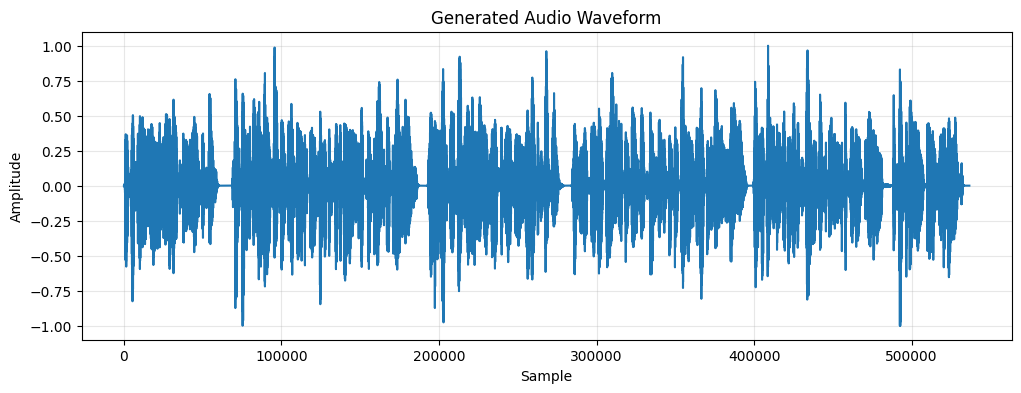

In [9]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

def play_and_analyze_audio(audio_path):
    """Play audio and show waveform analysis"""
    if not audio_path or not os.path.exists(audio_path):
        print("❌ No audio file to play")
        return

    print(f"🔊 Playing audio: {audio_path}")

    # Play audio
    ipd.display(ipd.Audio(audio_path))

    # Load and analyze waveform
    try:
        waveform, sample_rate = torchaudio.load(audio_path)
        duration = waveform.shape[1] / sample_rate

        print(f"📊 Audio Analysis:")
        print(f"   Duration: {duration:.2f} seconds")
        print(f"   Sample Rate: {sample_rate} Hz")
        print(f"   Channels: {waveform.shape[0]}")

        # Plot waveform
        plt.figure(figsize=(12, 4))
        plt.plot(waveform[0].numpy())
        plt.title("Generated Audio Waveform")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.grid(True, alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"❌ Error analyzing audio: {e}")

# Play the generated audio
if local_path:
    play_and_analyze_audio(local_path)

Cell 10: Parameter Experimentation

---


Test different parameter combinations

In [10]:
def experiment_with_parameters(text, model):
    """Generate multiple versions with different parameter combinations"""

    experiments = [
        {"name": "Neutral", "exaggeration": 0.5, "cfg_weight": 0.5},
        {"name": "Expressive", "exaggeration": 0.8, "cfg_weight": 0.4},
        {"name": "Calm", "exaggeration": 0.3, "cfg_weight": 0.6},
        {"name": "Dramatic", "exaggeration": 1.0, "cfg_weight": 0.3},
    ]

    short_text = "Hello! This is a test of different voice parameters."

    print("🧪 PARAMETER EXPERIMENTS")
    print("=" * 50)

    for exp in experiments:
        print(f"\n🎭 Testing: {exp['name']}")
        print(f"   Exaggeration: {exp['exaggeration']}, CFG Weight: {exp['cfg_weight']}")

        try:
            gen_params = {
                "text": short_text,
                "exaggeration": exp['exaggeration'],
                "cfg_weight": exp['cfg_weight']
            }

            if config.voice_sample_path and os.path.exists(config.voice_sample_path):
                gen_params["audio_prompt_path"] = config.voice_sample_path

            wav = model.generate(**gen_params)

            # Save and play
            filename = f"experiment_{exp['name'].lower()}.wav"
            filepath = f"/content/{filename}"
            torchaudio.save(filepath, wav, model.sr)

            print(f"   ✅ Generated: {filename}")
            print(f"   🔊 Playing...")
            ipd.display(ipd.Audio(filepath))

        except Exception as e:
            print(f"   ❌ Error: {e}")

# Run experiments with a short text
experiment_with_parameters("Hello! This is a test of different voice parameters.", model)

🧪 PARAMETER EXPERIMENTS

🎭 Testing: Neutral
   Exaggeration: 0.5, CFG Weight: 0.5


Sampling:   7%|▋         | 71/1000 [00:02<00:30, 30.11it/s]


   ✅ Generated: experiment_neutral.wav
   🔊 Playing...



🎭 Testing: Expressive
   Exaggeration: 0.8, CFG Weight: 0.4


Sampling:   7%|▋         | 71/1000 [00:02<00:29, 31.46it/s]


   ✅ Generated: experiment_expressive.wav
   🔊 Playing...



🎭 Testing: Calm
   Exaggeration: 0.3, CFG Weight: 0.6


Sampling:   8%|▊         | 83/1000 [00:02<00:33, 27.75it/s]


   ✅ Generated: experiment_calm.wav
   🔊 Playing...



🎭 Testing: Dramatic
   Exaggeration: 1.0, CFG Weight: 0.3


Sampling:   6%|▋         | 63/1000 [00:02<00:36, 25.94it/s]


   ✅ Generated: experiment_dramatic.wav
   🔊 Playing...
